In [1]:
!pip install autodistill -q
!pip install roboflow -q
!pip install autodistill_grounded_sam -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 12.6 MB/s eta 0:00:00


In [2]:
import supervision as sv
from tqdm.notebook import tqdm
import os
from pathlib import Path

from autodistill.detection import CaptionOntology
from autodistill_grounded_sam import GroundedSAM

Importing from timm.models.layers is deprecated, please import via timm.layers


In [17]:
ontology=CaptionOntology({
    "humans": "pedestrians",
    "cars": "vehicles",
    "signpost": "signboard"})


# x = os.listdir(DATASET_DIR_PATH)
# len(x)

In [18]:
Path('/kaggle/working/output_images').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/dataset/train/images').mkdir(parents=True, exist_ok=True)
Path('/kaggle/working/dataset/train/labels').mkdir(parents=True, exist_ok=True)

In [19]:
base_model = GroundedSAM(ontology=ontology)
DATASET_DIR_PATH = f"/kaggle/input/unannotated-images-boldstein/images (pre-annotation)"
output_dir = "/kaggle/working"

ANNOTATIONS_DIRECTORY_PATH = f"/kaggle/working/train/labels"
IMAGES_DIRECTORY_PATH = f"/kaggle/working/train/images"
DATA_YAML_PATH = f"/kaggle/working/data.yaml"
OUTPUT_IMAGES = f"/kaggle/working/output_images"

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


In [20]:
#Creating dataset splits

dataset = base_model.label(
    input_folder=DATASET_DIR_PATH,
    extension=".png",
    output_folder=output_dir)

Labeling /kaggle/input/unannotated-images-boldstein/images (pre-annotation)/nyc-00078.png: 100%|██████████| 150/150 [06:05<00:00,  2.44s/it]


Found /kaggle/working/train/images/nyc-00117.jpg as already present, not moving anything to /kaggle/working/train/images
Found /kaggle/working/train/labels/nyc-00117.txt as already present, not moving anything to /kaggle/working/train/labels
Found /kaggle/working/train/images/nyc-00042.jpg as already present, not moving anything to /kaggle/working/train/images
Found /kaggle/working/train/labels/nyc-00042.txt as already present, not moving anything to /kaggle/working/train/labels
Found /kaggle/working/train/images/nyc-00156.jpg as already present, not moving anything to /kaggle/working/train/images
Found /kaggle/working/train/labels/nyc-00156.txt as already present, not moving anything to /kaggle/working/train/labels
Found /kaggle/working/train/images/nyc-00140.jpg as already present, not moving anything to /kaggle/working/train/images
Found /kaggle/working/train/labels/nyc-00140.txt as already present, not moving anything to /kaggle/working/train/labels
Found /kaggle/working/train/imag

In [21]:
train_images_list = os.listdir("/kaggle/working/train/images")
valid_images_list = os.listdir("/kaggle/working/valid/images")

len(train_images_list), len(valid_images_list) #80:20 split

(149, 77)

In [22]:
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

149

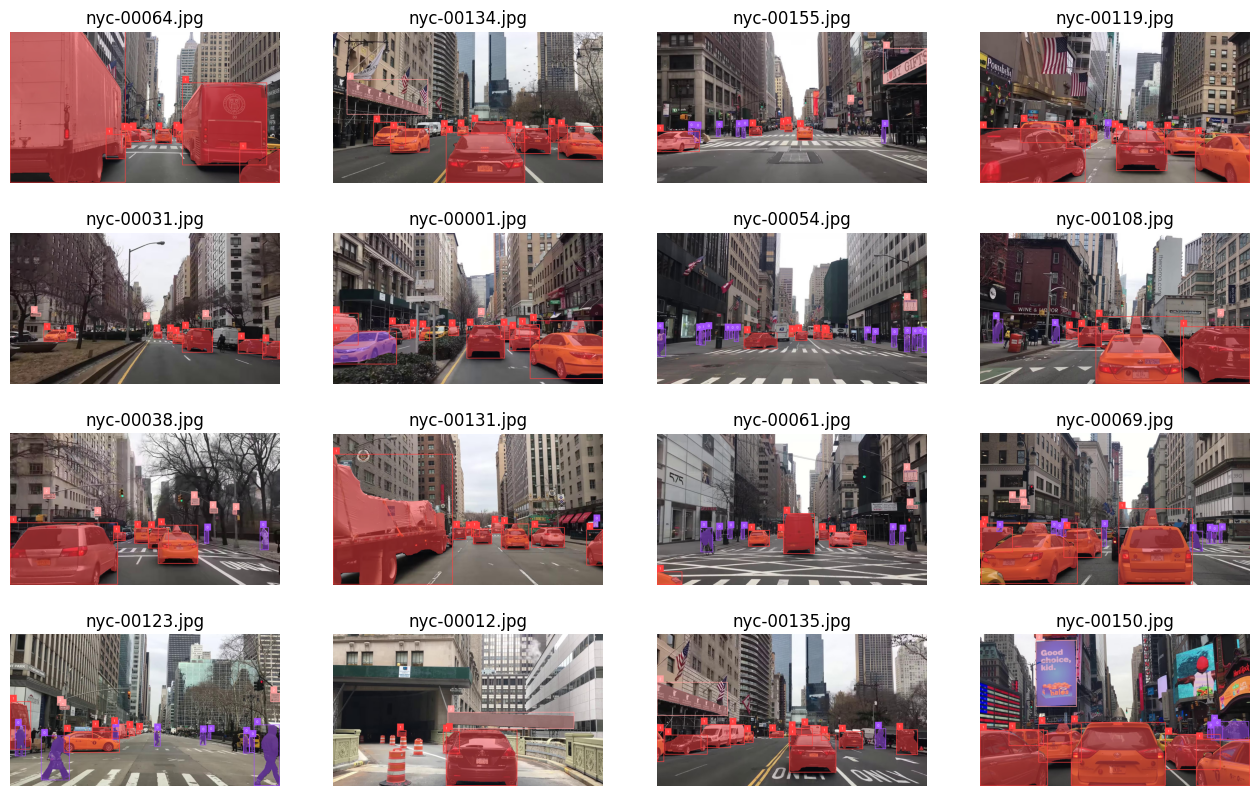

In [24]:
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 10)

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

images = []
image_names = []
for i, (image_path, image, annotation) in enumerate(dataset):
    if i == SAMPLE_SIZE:
        break
    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(
        scene=annotated_image, detections=annotation)
    annotated_image = box_annotator.annotate(
        scene=annotated_image, detections=annotation)
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=annotation)

    image_names.append(Path(image_path).name)
    images.append(annotated_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [25]:
import shutil
from IPython.display import FileLink

shutil.make_archive('outputs', 'zip', '/kaggle/working/')
FileLink(r'outputs.zip')

/kaggle/working/outputs.zip

# Note: I also did auto labelling using Roboto and finally used that to fine-tune the model.